# Lab 9. Bayesian analysis and Monte Carlo simulation
#### Computational Methods for Geoscience - Fall 2023
#### Instructor: Eric Lindsey

Due: Nov. 9, 2023

---------

In [67]:
# some useful imports and settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize

# new this week - you may need to install these, using whichever method works for your computer.
import emcee
import corner

%config InlineBackend.figure_format = 'retina' # better looking figures on high-resolution screens
# automatically reload modules when running, otherwise jupyter does not notice if our functions have changed
%load_ext autoreload
%autoreload 2

import time
import datetime

import fault_model
import geod_transform
import moment_tensor


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Mystery data

We have some data that seem to follow a sinusoidal function plus a linear trend. Not knowing much about the data, suppose we hypothesize that it can be fit by the following 5-parameter function:

$ y(x) = a\sin(bx+c) + dx + e $

Below, we have tried to fit this with scipy curve_fit. The results are not promising...

Scipy curve_fit found: a,b,c,d,e = [-3.18405498  2.76054131 -4.53757396  6.1313707   7.71590243]
Covariances:
 [[ 0.9997514  -0.02872103  0.04679058 -0.16878765  0.20806094]
 [-0.02872103  0.04884787 -0.12768717 -0.02808373  0.11862073]
 [ 0.04679058 -0.12768717  0.42053866  0.11425519 -0.41813508]
 [-0.16878765 -0.02808373  0.11425519  0.255173   -0.63524613]
 [ 0.20806094  0.11862073 -0.41813508 -0.63524613  2.06174842]]


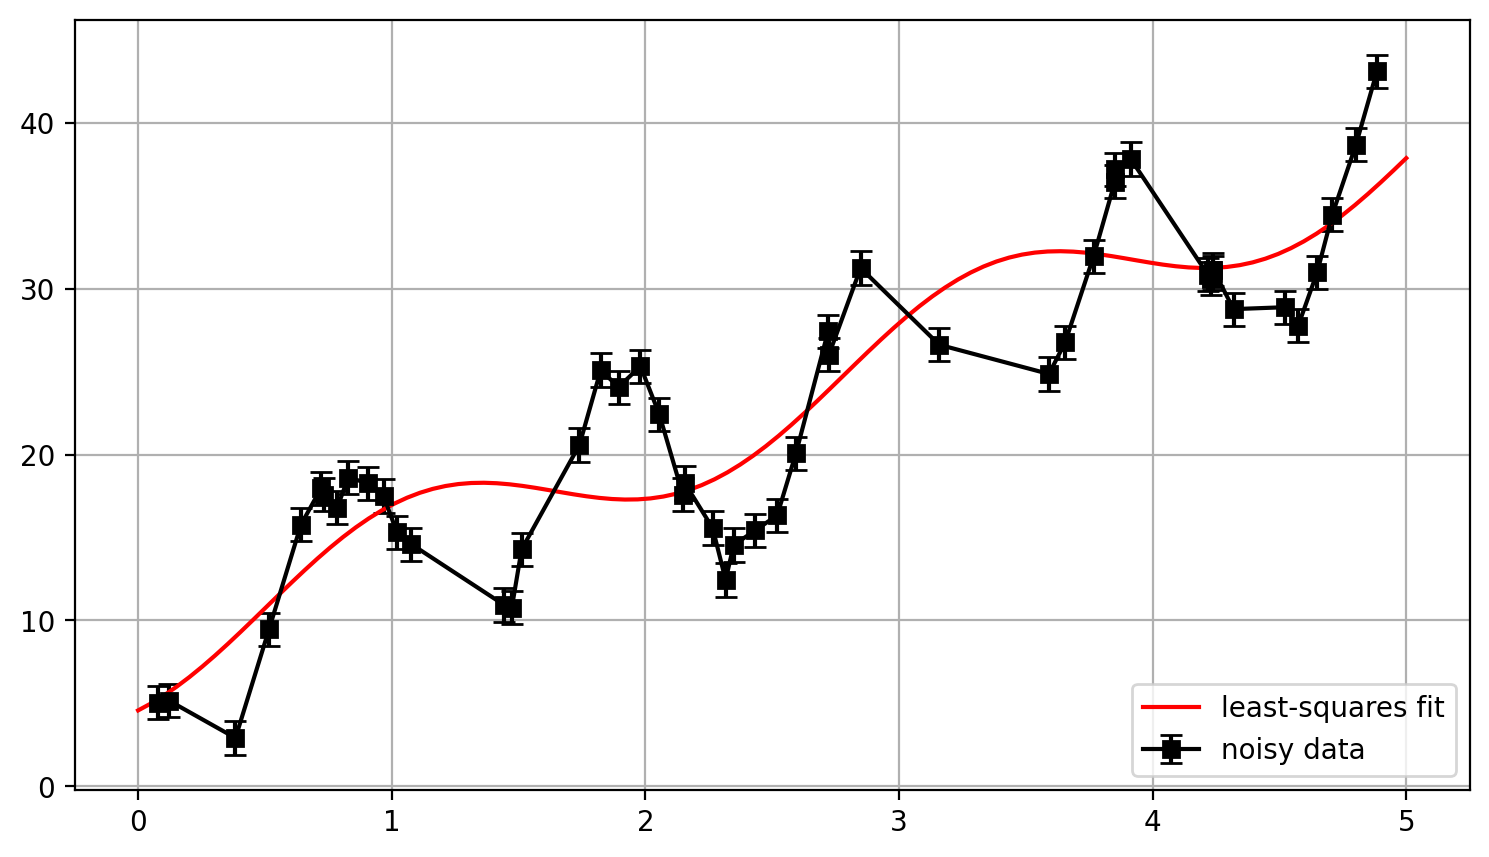

In [68]:
# load the data from the csv file

data = pd.read_csv('mystery_data.csv')
x=np.array(data['x'])
y=np.array(data['y'])
yerr=np.array(data['yerr'])

# create our "hypothesized" model

# define our model here - in this case, just a line. 
def my_model(x,*params):
    # this first line "unpacks" the list [params] into elements. 
    # An easier way to pass many variables to a function.
    a,b,c,d,e = params
    # Compute the model, and return the y values
    model = a*np.sin(b*x + c) + d*x + e
    return model

# here, p0 is the 'initial guess' for this method. 
# m is the model output, and mcov is the model covariance, or uncertainties.
m,mcov = scipy.optimize.curve_fit(my_model,x,y,p0=np.ones(5))
print('Scipy curve_fit found: a,b,c,d,e =',m)
print('Covariances:\n',mcov)

# create a new, evenly sampled x array for plotting the "fitted" function
x_plot = np.linspace(0,5,100)

# to get the predicted y-values, we can just call our function with the 
# model parameters determined by scipy.
lsq_model = my_model(x_plot,*m) 

plt.figure(figsize=(9,5))
plt.errorbar(x,y,yerr=yerr,fmt='-ks',label='noisy data',capsize=4)
plt.plot(x_plot,lsq_model, '-r', label='least-squares fit')
plt.legend(loc='lower right')
plt.grid()
plt.show()


## Assignment: fit the data with Monte Carlo

We should be able to do much better than this with Monte Carlo sampling! 

Modify the example code from the notes to estimate the five parameters that were used to generate these data.

Some things to think about:

- You will need to write 3 functions: the log-likelihood function, the log-prior function, and the log-probability function. Most of these will be nearly the same as in the line-fitting example.

- Think about what starting locations you give the model for each parameter, and the number of samples to generate for your sampler. If you are having trouble, try re-running your sampler using the best-fitting parameters from the first run as your initial guess for the second run.

- Think about the prior distribution - a uniform range is probably fine, but what is the range? Think about this particularly for parameter 'c', the phase shift - if you make the range too large you could get multiple solutions!

Your final results should contain a plot of the best-fitting solution to the data, and the probability distribution function plots showing nice shapes (they should be nearly gaussian) for each of the parameters.

### Log-Likelihood Function

In [73]:
# "log likelihood" function for the sampler
def lnlike_line(params, x, y, yerr):
    # get the predicted model values
    ypred = my_model(x, *params)
    # compute the (negative) misfit - sum of the residuals squared, scaled by the data uncertainties
    misfit = -0.5*np.sum(((y-ypred)/yerr)**2)
    return misfit

### Log-Prior Function

In [75]:
# set our priors - we use this to set bounds on the parameters.
# return value is set to negative infinity if any parameters are outside their bounds, otherwise it is zero. 
# this is because we have taken the log() of our probability distribution. So 10^0 = 1, while 10^-np.inf = 0.
# if we wanted gaussian priors, or other types, we could also implement them here instead of bounds.
def lnprior_line(params):
    # define bounds here
    minvals = np.array([-10, -10, -10, -10, -10])
    maxvals = np.array([10, 10, 10, 10, 10])
    if any(params-minvals<0) or any(params-maxvals>0): # check if any bounds are exceeded
        return -np.inf # Log-prior is -inf outside the range
    else:
        return 0.0 # Log-prior is 0 within the specified range

### Log Probability Function

In [76]:
#finally, this function puts together all the above, to determine the actual log(probability) of a set of parameters.
def lnprob_line(params, x, y, yerr):
    prior = lnprior_line(params)
    if np.isinf(prior):
        return -np.inf
    else:
        return prior + lnlike_line(params, x, y, yerr) #recall if lp not -inf, its 0, so this just returns likelihood

### The Sampler...
Re-run with initials set very close to parameters found from first run

In [113]:
# collect our variables to feed this function:
# 1. package our input x,y,yerr data together:
data = (x,y,yerr)

# 2. decide the number of random walks and how many steps in each one:
nwalkers = 100
niter = 3000

# 3. set initial guesses for each random walk
initial=[-7, 6, 0, 6, 7]
# use this code to set up initial points for each random walk that are slightly different from each other
ndim = len(initial)
p0 = [np.array(initial) + 1e-1 * np.random.randn(ndim) for i in range(nwalkers)]

# create the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_line, args=data)

# start the timer
tstart = time.time()

# run some initial steps to discard, so the walkers get into a reasonable starting location
print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, niter)
sampler.reset()

print("Running production...")
pos, prob, state = sampler.run_mcmc(p0, niter)

# end the timer
tend = time.time()
print("Done! Sampling took %f seconds." %(tend-tstart))

Running burn-in...
Running production...
Done! Sampling took 23.960380 seconds.


### PLOT: MMC Samples

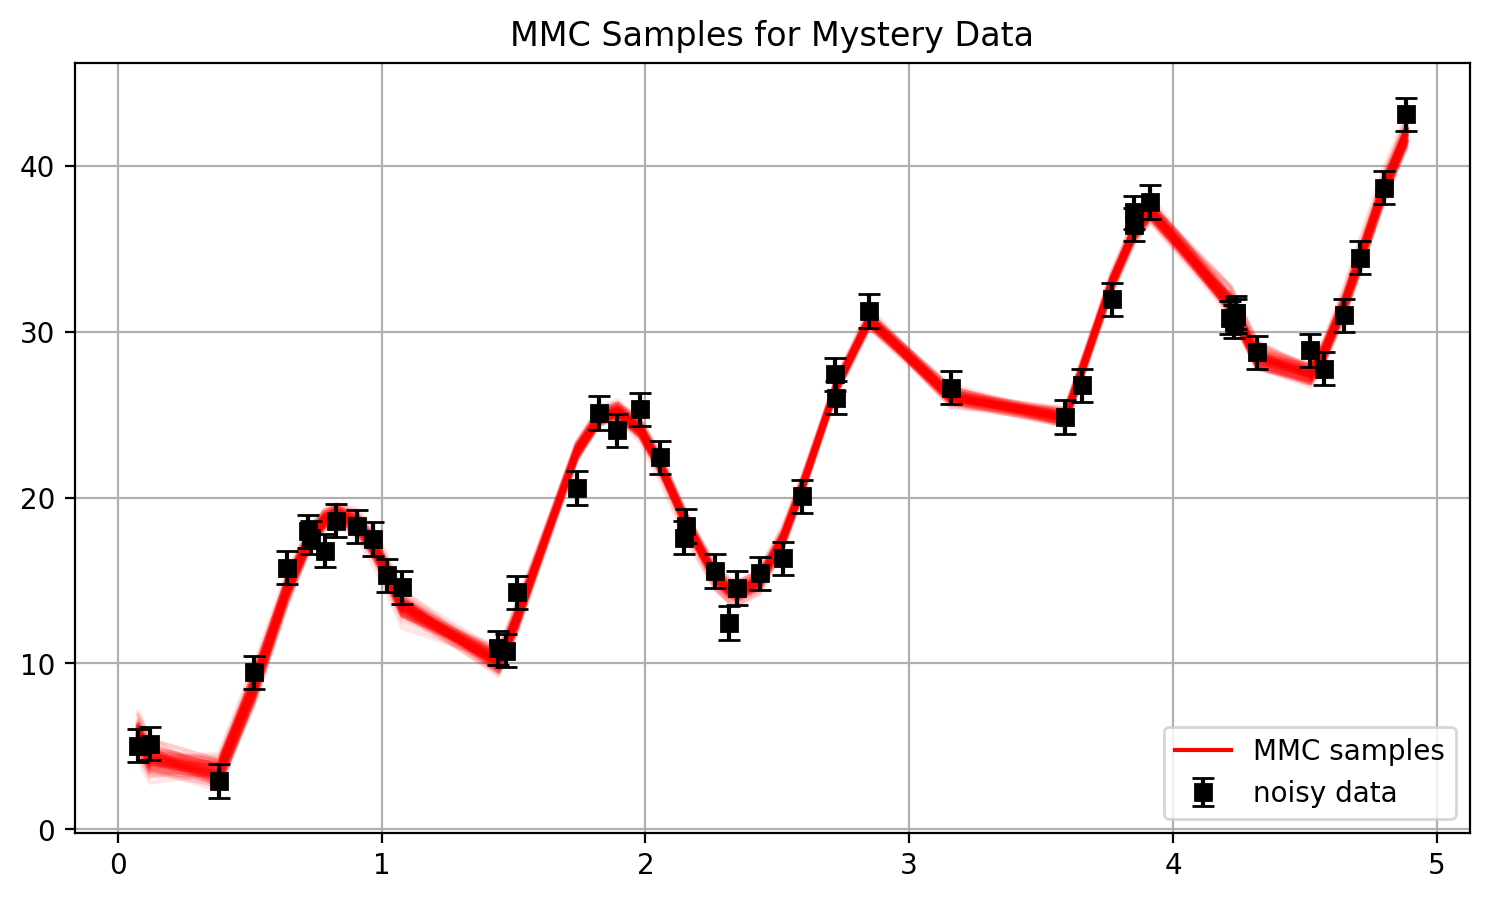

In [114]:
# plot some of the samples, selected at random
samples = sampler.flatchain

plt.figure(figsize=(9,5))

for params in samples[np.random.randint(len(samples), size=100)]: # plot 100 random samples
    plt.plot(x, my_model(x,*params), color="r", alpha=0.1)
#Create a dummy plot outside the loop for the legend
plt.errorbar(x,y,yerr,fmt='ks',label='noisy data',capsize=4)
plt.plot([], [], color="r", label='MMC samples')
plt.legend(loc='lower right')
plt.title('MMC Samples for Mystery Data')
plt.grid()
plt.show()

### PLOT: The Best Fitting Sample

MCMC Best fit:  [-7.01554589  6.02219818 -0.19409612  5.95096554  7.12451668]
LSQ Best fit:  [-3.18405498  2.76054131 -4.53757396  6.1313707   7.71590243]


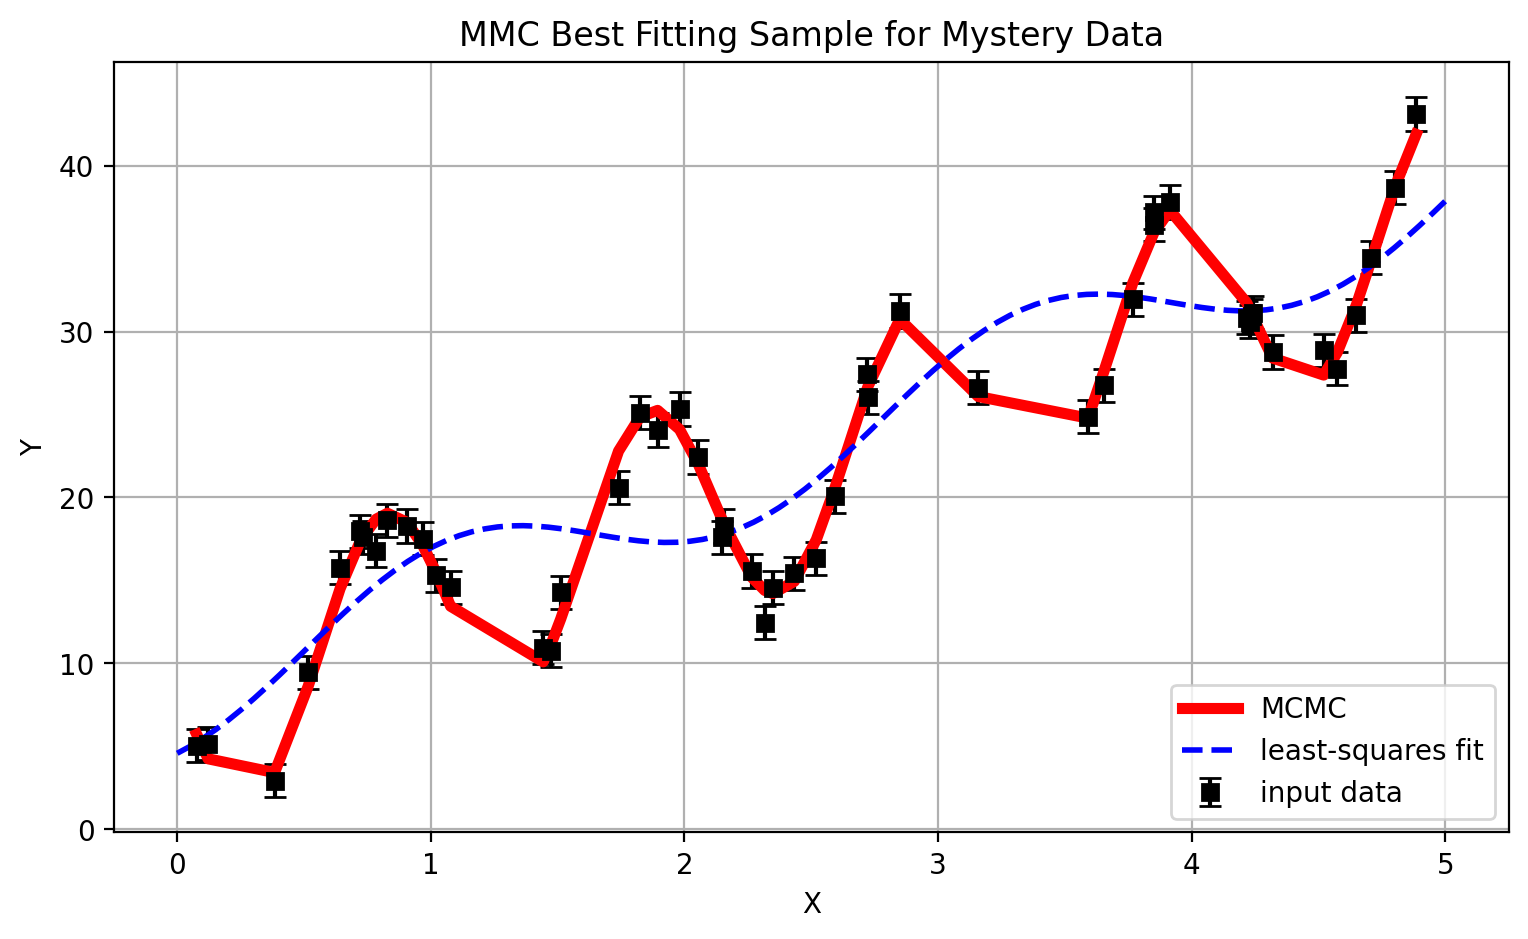

In [115]:
# np.argmax finds the location of the maximum element in an array.
# so samples[np.argmax(sampler.flatlnprobability)] finds the location in the chain with the maximum log-likelihood,
# and then returns the model that has that likelihood
params_max  = samples[np.argmax(sampler.flatlnprobability)]
print('MCMC Best fit: ',params_max)
print('LSQ Best fit: ',m) 

# compute the line model for this set of parameters
best_fit_model = my_model(x,*params_max)

plt.figure(figsize=(9,5))
plt.errorbar(x,y,yerr,fmt='ks',label='input data',capsize=4)
plt.plot(x, best_fit_model,'-r',label="MCMC",linewidth=4)
plt.plot(x_plot,lsq_model, '--b', label='least-squares fit', linewidth=2)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend(loc='lower right')
plt.title('MMC Best Fitting Sample for Mystery Data')
plt.show()

### PLOT: Probability Distribution Functions

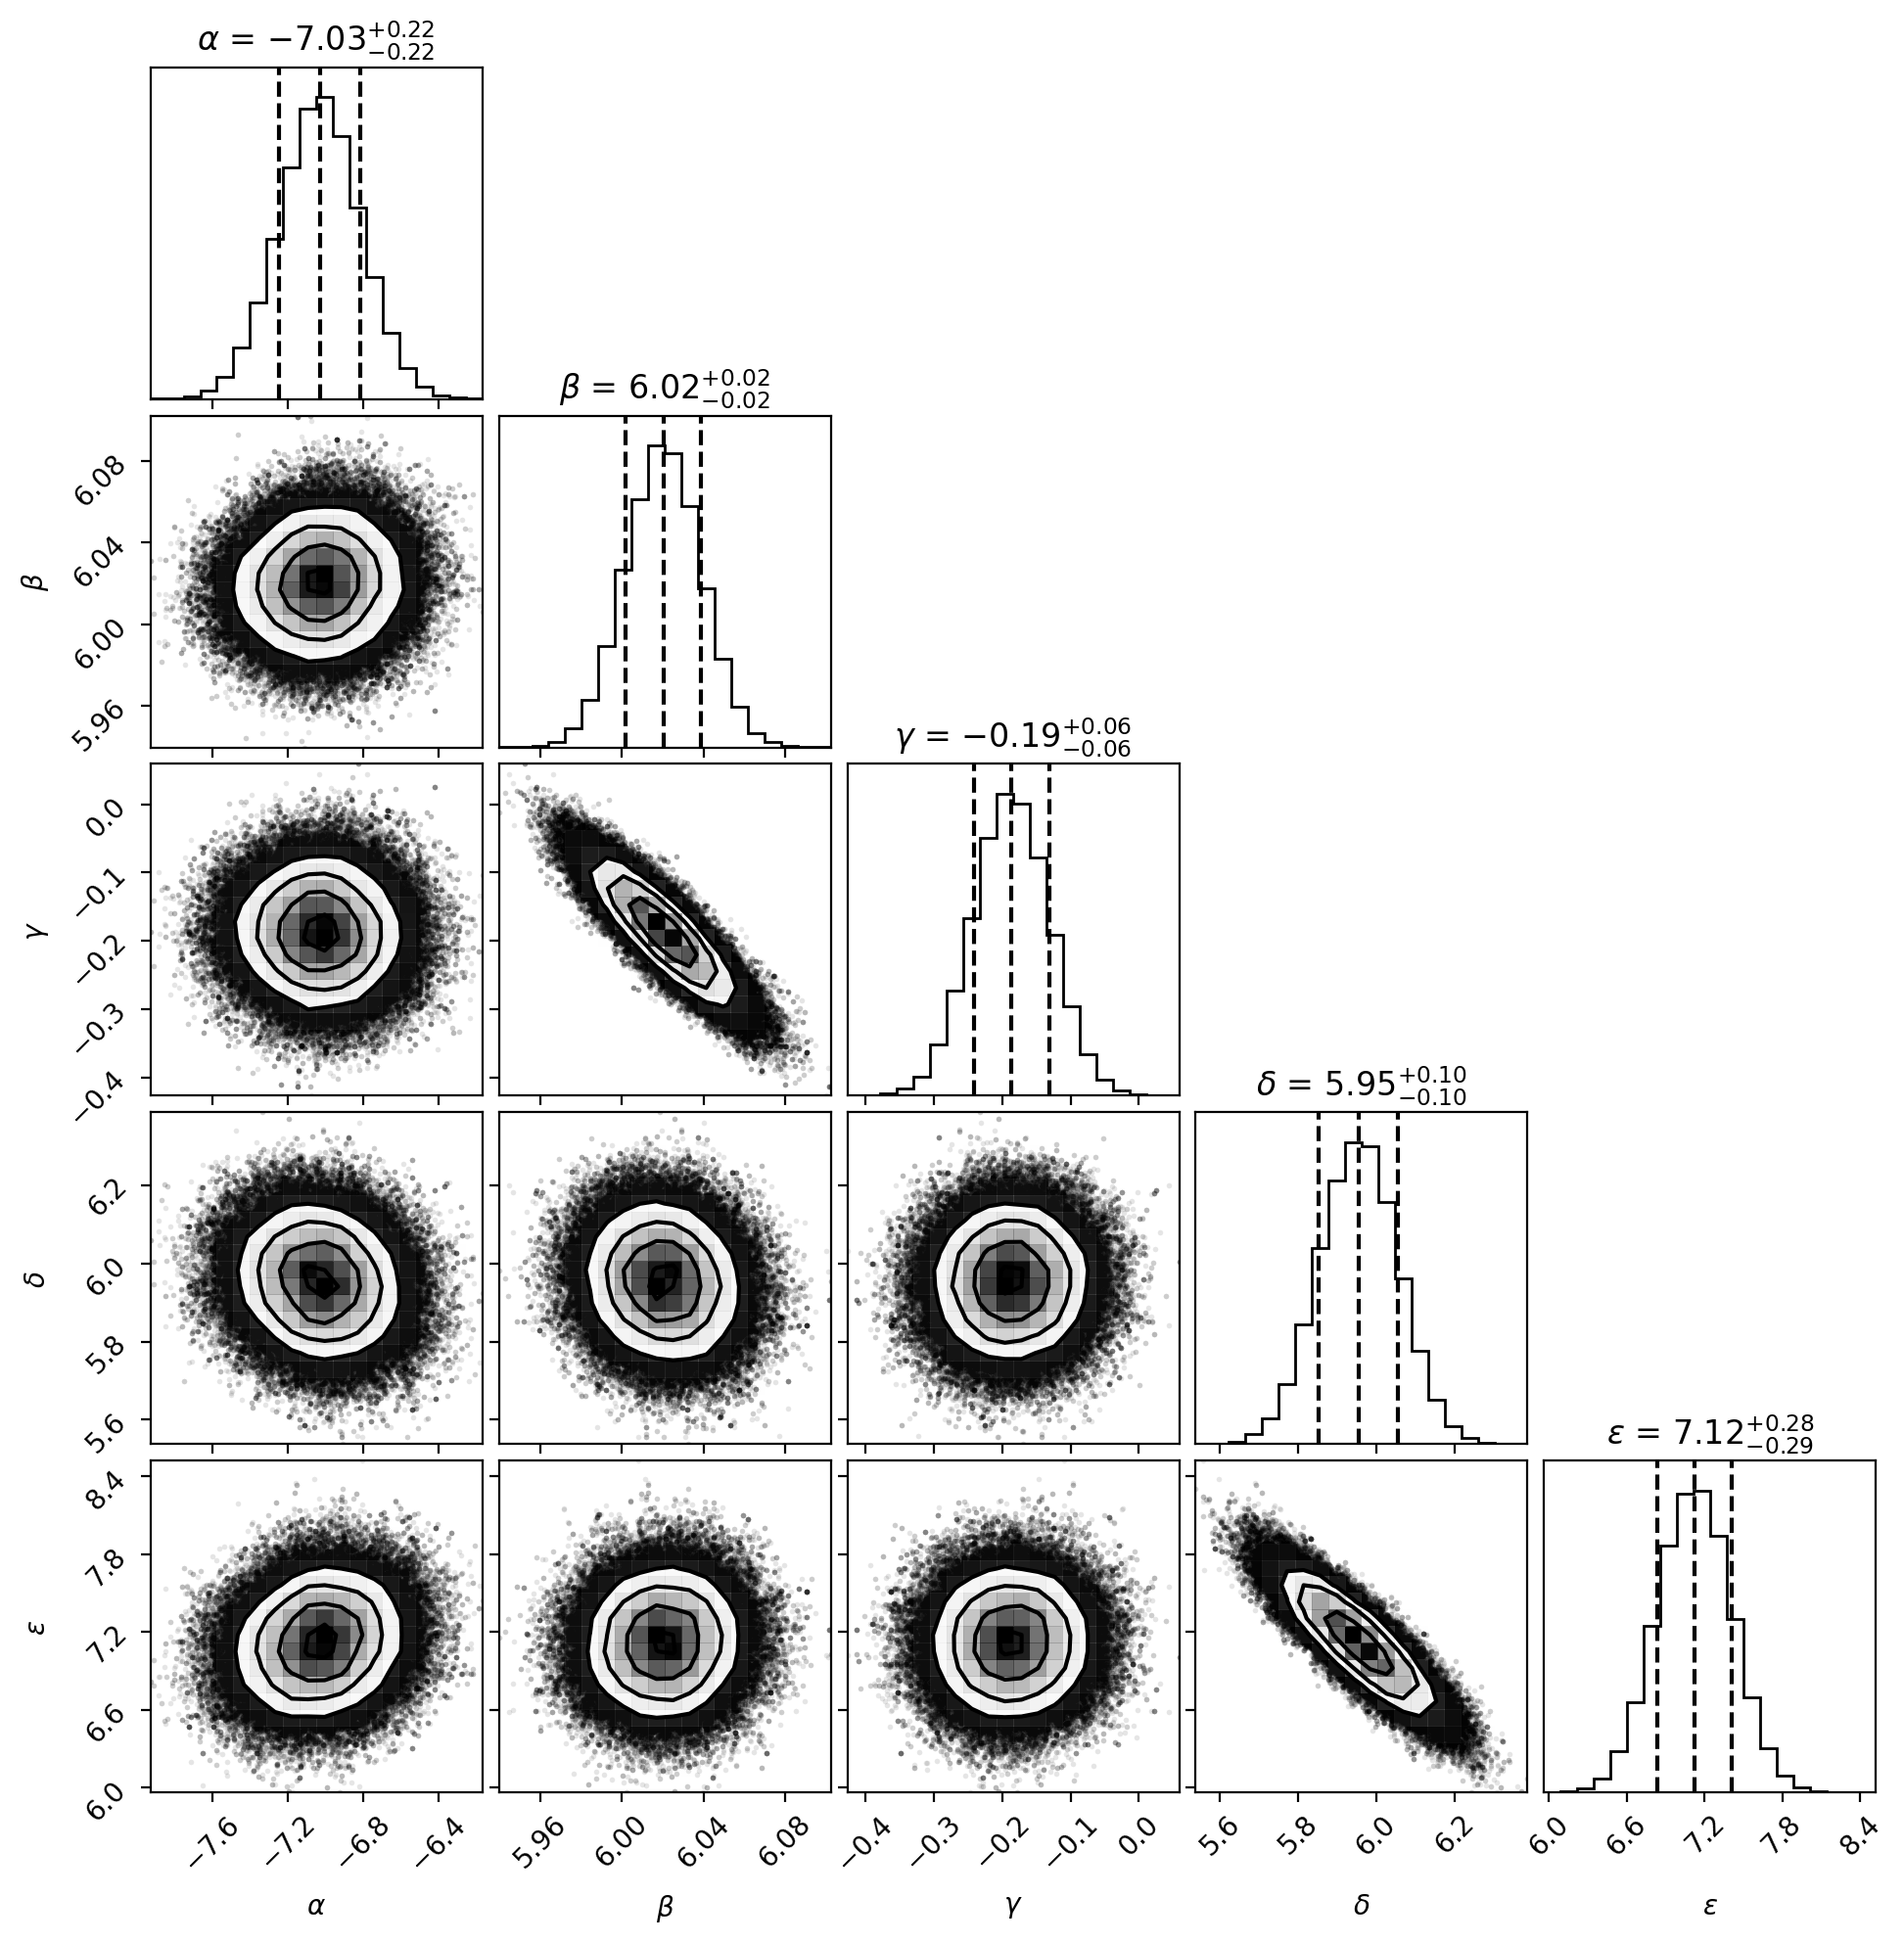

In [117]:
# plot the PDFs of the samples
labels = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$', r'$\epsilon$']

myFig = plt.figure(figsize=(10, 10))
fig = corner.corner(samples,show_titles=True,bins=20,use_math_text=True,fig=myFig,
                    labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])
